In [3]:
'''
将 ALFALFA dist 转为 z 匹配
将ra dec z 化为一个量级进行匹配
'''
import k3match as k3    # 二叉树算法筛选星系
import pandas as pd
import numpy as np
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性&防止指针

# 常数设定
H0 = 70    # 哈伯常数(km/s/Mpc)
c0 = 3*10**5    # 光速(km/s)

# 获取manga数据
# ra,dec,redshift
vac = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
manga_data = np.zeros([4675,3],dtype=float) # 初始化数组
basic = vac[1].data
# 获取ra和dec信息
manga_data[:,0] = copy(basic['OBJRA'])    # 去除只读属性
manga_data[:,1] = copy(basic['OBJDEC'])    # 去除只读属性
# 获取红移数据
manga_data[:,2] = copy(basic['REDSHIFT'])    # 去除只读属性

# 导入 ALFALFA 数据
a_100_path = '/root/cosmos/data/alfalfa.100.csv'
a_2018_path = '/root/cosmos/data/alfalfa.2018.csv'
a100_data = pd.read_csv(a_100_path)
a2018_data = pd.read_csv(a_2018_path)
a100 = a100_data[['HIra','HIdec','dist']].values
a2018 = a2018_data[['RAdeg_HI','DECdeg_HI','Dist']].values

# distance --> redshift
a100[:,2] = a100[:,2]*H0/c0
a2018[:,2] = a2018[:,2]*H0/c0


# k3match 匹配
# 使用k3匹配：nsa&nair
idx_alfa, idx_manga, d = k3.cartesian(manga_data[:,0], manga_data[:,1], manga_data[:,2],    # manga的ra dec z
                                     a100[:,0], a100[:,1], a100[:,2],    # alfalfa的ra dec z
                                     0.4)    # 搜索半径

vac.close()


a,tmp_id = np.unique(idx_alfa,return_index=True)
print("去除前",np.shape(idx_alfa))
print("去除后",np.shape(tmp_id))

去除前 (250,)
去除后 (200,)


In [53]:
dist=0.1
ax = np.array([1,1,2,3,4,5,5,7,6,9,66,7])
ay = np.array([1,1,2,3,4,5,5,7,6,9,66,7])
az = np.array([1,1,2,3,4,5,5,7,6,9,66,7])
bx = np.array([1.1,1.2,1.9,2,5,6,7,7,9,66,1])
by = np.array([1.1,1.2,1.9,2,5,6,7,7,9,66,1])
bz = np.array([1.1,1.2,1.9,2,5,6,7,7,9,66,1])

id_x, nst_d = k3.nearest_cartesian(ax,ay,az,
                                  bx,by,bz)
print("最近邻点数组位置：",id_x,"\n距离为：",nst_d)
id_a, id_b, d = k3.cartesian(ax,ay,az,
                            bx,by,bz,
                            dist)
print("最初匹配数量：",id_a.shape[0])

seq_a, uq_ida, num_a = np.unique(id_a, return_index=True, return_counts=True)
seq_b, uq_idb, num_b = np.unique(id_b, return_index=True, return_counts=True)
print("unique初次筛选数量：",uq_ida.shape[0])

ida_1 = uq_ida[num_a==1]
idb_1 = uq_idb[num_b==1]
tmp_a = np.ones(id_a.shape)*False
tmp_a[ida_1]=True
tmp_b = np.ones(id_b.shape)*False
tmp_b[idb_1]=True
uq_id = (tmp_a==True)&(tmp_b==True)
print("最终一对一数量：",id_a[uq_id].shape[0])

最近邻点数组位置： [ 1  1  2  2  5  8 11 11  9 10  0] 
距离为： [0.17320508 0.34641016 0.17320508 0.         0.         0.
 0.         0.         0.         0.         0.        ]
最初匹配数量： 12
unique初次筛选数量： 10
最终一对一数量： 4


In [44]:

print(tmp_a)
tmp_a == False

[1. 1. 0. 0. 1. 1. 1. 0. 0.]


array([False, False,  True,  True, False, False, False,  True,  True])

In [36]:
print(id_a)
print(id_b)
print(seq_a)
print(seq_b)
print(uq_ida)
print(num_a)
print(num_b)

[0 1 2 2 6 5 8 7 7]
[0 0 2 3 4 4 5 6 7]
[0 1 2 5 6 7 8]
[0 2 3 4 5 6 7]
[0 1 2 5 4 7 6]
[1 1 2 1 1 2 1]
[2 1 1 2 1 1 1]


In [34]:
a = np.array([True,0,1,7])
b = np.array([False,0,0,77])
a&b

array([0, 0, 0, 5])

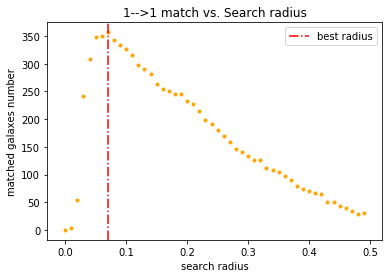

最佳搜索半径为 0.07


In [71]:
# 寻找最佳匹配半径
'''
因为红移比角度量级小2，因此所有的红移 乘以100，再进行匹配
使用我的方法搜索最佳匹配半径：
    1.调整数量级
    2.使用k3match匹配
    3.使用numpy的unique进行寻找完全1：1匹配的星系，计数
    4.得到 匹配数量-半径 图
'''
import matplotlib.pyplot as plt    # 画图[Matlab形式]
import k3match as k3    # 二叉树算法筛选星系
import pandas as pd
import numpy as np
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性&防止指针
from astropy import units as u
from astropy.coordinates import SkyCoord

num_for = 50    # 循环次数
delta_r = 0.01    # 搜索半径变化值
search_r = 0    # 搜索半径最小值
# 常数设定
H0 = 70    # 哈伯常数(km/s/Mpc)
c0 = 3*10**5    # 光速(km/s)

# 初始化 画图数组 匹配个数-搜索半径
plt_sum_r = np.zeros([num_for,2])

# 获取manga数据
# ra,dec,redshift
vac = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
basic = vac[1].data
# 获取ra和dec信息
manga_data[:,0] = copy(basic['OBJRA'])    # 去除只读属性
manga_data[:,1] = copy(basic['OBJDEC'])    # 去除只读属性
# 获取红移数据
manga_data[:,2] = copy(basic['REDSHIFT'])    # 去除只读属性

# 导入 ALFALFA 数据
a_100_path = '/root/cosmos/data/alfalfa.100.csv'
a_2018_path = '/root/cosmos/data/alfalfa.2018.csv'
a100_data = pd.read_csv(a_100_path)
a2018_data = pd.read_csv(a_2018_path)
a100 = a100_data[['HIra','HIdec','dist']].values
a2018 = a2018_data[['RAdeg_HI','DECdeg_HI','Dist']].values

# distance --> redshift，v==c*z==H0*d => z = H0*D/c
a100[:,2] = a100[:,2]*H0/c0
a2018[:,2] = a2018[:,2]*H0/c0
# 调整为一个数量级
a100[:,2] /= 50.
a2018[:,2] /= 20.

pre_mch_nm=0

# 开始循环
for i in range(0,num_for):
    # 调整一下半径变化
    #if search_r>0.023:
    #    search_rr = 10*search_r
    #else:
     #   search_rr = search_r
    search_rr = search_r
    
    # 使用k3match
    idx_manga,idx_alfa,dd = k3.cartesian(manga_data[:,0],manga_data[:,1],manga_data[:,2],
                                         a2018[:,0], a2018[:,1], a2018[:,2],search_rr)
    id_a = idx_manga
    id_b = idx_alfa
    seq_a, uq_ida, num_a = np.unique(id_a, return_index=True, return_counts=True)
    seq_b, uq_idb, num_b = np.unique(id_b, return_index=True, return_counts=True)
    #print("unique初次筛选数量：",uq_ida.shape[0])

    ida_1 = uq_ida[num_a==1]
    idb_1 = uq_idb[num_b==1]
    tmp_a = np.ones(id_a.shape)*False
    tmp_a[ida_1]=True
    tmp_b = np.ones(id_b.shape)*False
    tmp_b[idb_1]=True
    uq_id = (tmp_a==True)&(tmp_b==True)
    #print("最终一对一数量：",id_a[uq_id].shape[0])
    
    
    
    
    
    crnt_mch_nm = id_a[uq_id].shape[0]
    match_num = crnt_mch_nm#crnt_mch_nm-pre_mch_nm
    pre_mch_nm = crnt_mch_nm
    plt_sum_r[i,0] = match_num    # y轴，匹配星系个数
    plt_sum_r[i,1] = search_rr    # x轴，搜索半径radius
    
    search_r += delta_r

# 画散点图
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('1-->1 match vs. Search radius')    #设置标题
plt.xlabel('search radius')    #设置X轴标签
plt.ylabel('matched galaxes number')    #设置Y轴标签
x = plt_sum_r[:,1]
y = plt_sum_r[:,0]
ax1.scatter(x,y,c = 'orange',marker = '.')


min_unmatched = np.where(plt_sum_r[:,0]==np.max(plt_sum_r[:,0]))[0][0]
optimal_r = plt_sum_r[:,1][min_unmatched]
plt.axvline(optimal_r,color='r',linestyle='-.',label="best radius")


plt.legend(loc='best')    #设置图标
plt.show()    #显示所画的图

print('最佳搜索半径为',optimal_r)
vac.close()

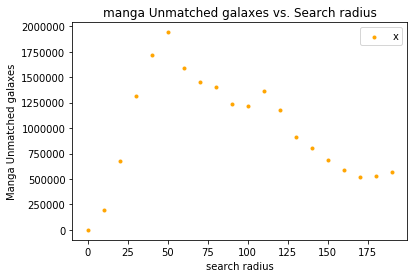

最佳搜索半径为 0.0


匹配到MaNGA星系个数为： 4675


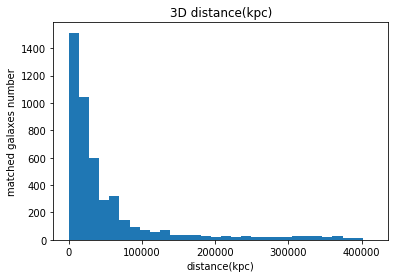

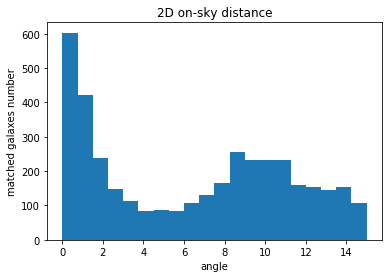

In [129]:
'''
使用astrpy，使用 ra, dec, proper distance(kpc) 进行匹配
和上方的 k3 匹配结果做对比
'''
import matplotlib.pyplot as plt    # 画图[Matlab形式]
import k3match as k3    # 二叉树算法筛选星系
import pandas as pd
import numpy as np
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性&防止指针
from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息

# 常数设定
H0 = 70    # 哈伯常数(km/s/Mpc)
c0 = 3*10**5    # 光速(km/s)
# 获取manga数据
# ra,dec,redshift
vac = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
manga_data = np.zeros([4675,3],dtype=float) # 初始化数组
basic = vac[1].data
# 获取ra和dec信息
manga_data[:,0] = copy(basic['OBJRA'])    # 去除只读属性
manga_data[:,1] = copy(basic['OBJDEC'])    # 去除只读属性
# 获取红移数据
manga_data[:,2] = copy(basic['REDSHIFT'])    # 去除只读属性

# 导入 ALFALFA 数据
a_100_path = '/root/cosmos/data/alfalfa.100.csv'
a_2018_path = '/root/cosmos/data/alfalfa.2018.csv'
a100_data = pd.read_csv(a_100_path)
a2018_data = pd.read_csv(a_2018_path)
a100 = a100_data[['HIra','HIdec','dist']].values
a2018 = a2018_data[['RAdeg_HI','DECdeg_HI','Dist']].values
# redshift --> distance，v==c*z==H0*d => d=cz/H0*10**3(kpc)
manga_data[:,2] = c0*manga_data[:,2]/H0*10**3
a100[:,2] *= 10**3
a2018[:,2] *= 10**3

# # distance --> redshift z=H0*d/c
# manga_data[:,2] *=100
# a100[:,2] *= H0/c0*100
# a2018[:,2] *= H0/c0*100

ra1 = manga_data[:,0]
dec1 = manga_data[:,1]
distance1 = manga_data[:,2]
ra2 = a2018[:,0]
dec2 = a2018[:,1]
distance2 = a2018[:,2]

manga_obj = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree, distance=distance1*u.kpc)
alfa_des = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree, distance=distance2*u.kpc)
idx, d2d, d3d = manga_obj.match_to_catalog_3d(alfa_des)

print("匹配到MaNGA星系个数为：",idx.shape[0])
plt.hist(d3d.value,bins=30)#,label="3D distance distribution")
plt.title("3D distance(kpc)")
plt.xlabel('distance(kpc)')    #设置X轴标签
plt.ylabel('matched galaxes number')    #设置Y轴标签
#plt.legend(loc="best")
plt.show()

plt.hist(d2d.value[d2d.value<15],bins=20)
plt.title('2D on-sky distance')    #设置标题
plt.xlabel('angle')    #设置X轴标签
plt.ylabel('matched galaxes number')    #设置Y轴标签
plt.show()


vac.close()


# MaNGA & ALFALFA `银道坐标` 天区分布图

In [1]:
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性
import numpy as np    # 数组
import matplotlib.pyplot as plt    # 画图[Matlab形式]
from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
import pandas as pd

warnings.filterwarnings('ignore')    # 不显示warning信息
# 获取manga数据
# ra,dec,redshift
vac = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
manga_data = np.zeros([4675,2],dtype=float) # 初始化数组
basic = vac[1].data


# 获取ra和dec信息
manga_data[:,0] = copy(basic['OBJRA'])    # 去除只读属性
manga_data[:,1] = copy(basic['OBJDEC'])    # 去除只读属性

# 根据ra,dec画出星系分布图

# 获取ra,dec值
manga_ra = manga_data[:,0]
manga_dec = manga_data[:,1]

# 转换ra, dec至银道坐标
coor_origin = SkyCoord(ra=manga_ra*u.degree, dec=manga_dec*u.degree, frame='icrs')
coor_traned = coor_origin.galactic
a=coor_traned.to_string('decimal')
b=np.array(a)
c = np.char.split(b,sep=' ')
def f(x):
    lala = np.array(x)
    return lala
# 使用map函数直接将数组中所有的list转换为np格式
a = np.array(list(map(f,c)))
a = a.astype(float)
coor_traned = copy(a)

# 导入 ALFALFA 数据
a_100_path = '/root/cosmos/data/alfalfa.100.csv'
a_2018_path = '/root/cosmos/data/alfalfa.2018.csv'
a100_data = pd.read_csv(a_100_path)
a2018_data = pd.read_csv(a_2018_path)
a100 = a100_data[['HIra','HIdec','dist']].values
a2018 = a2018_data[['RAdeg_HI','DECdeg_HI','Dist']].values
alfa_ra = a100[:,0]# a2018[:,0]
alfa_dec = a100[:,1]# a2018[:,1]
# ALFALFA的ra dec转换为银道坐标
# 转换ra, dec至银道坐标
coor_origin = SkyCoord(ra=alfa_ra*u.degree, dec=alfa_dec*u.degree, frame='icrs')
alfa_coor_traned = coor_origin.galactic
a=alfa_coor_traned.to_string('decimal')
b=np.array(a)
c = np.char.split(b,sep=' ')
def f(x):
    lala = np.array(x)
    return lala
# 使用map函数直接将数组中所有的list转换为np格式
a = np.array(list(map(f,c)))
a = a.astype(float)
alfa_coor_traned = copy(a)


vac.close()

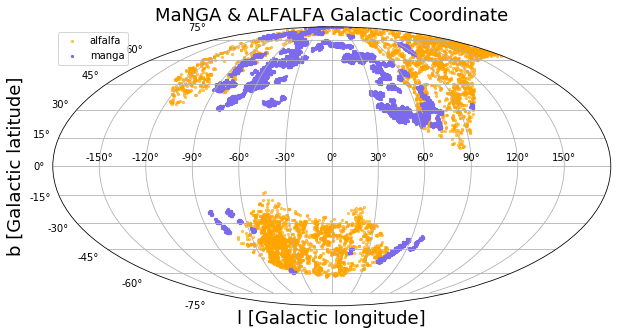

In [2]:
# 画图
plt.figure(figsize=(10,6))
plt.subplot(111,projection="mollweide")
manga_gx = coor_traned[:,0]
manga_gy = coor_traned[:,1]
manga_gx = (manga_gx-130)*np.pi/180
manga_gy = (manga_gy)*np.pi/180
alfa_gx = (alfa_coor_traned[:,0]-130)*np.pi/180
alfa_gy = (alfa_coor_traned[:,1])*np.pi/180
# plt.plot(manga_gx,manga_gy,'.',color = '#7c6aed',label='manga',alpha=0.25)
plt.scatter(alfa_gx,alfa_gy,s=5,color = 'orange',label='alfalfa',alpha=0.6)
plt.scatter(manga_gx,manga_gy,s=5,color = '#7c6aed',label='manga',alpha=1)
plt.grid()

plt.legend(loc="best")# 设置图例
plt.ylabel("b [Galactic latitude]",fontsize = 18)
plt.xlabel("l [Galactic longitude]",fontsize = 18)
plt.title("MaNGA & ALFALFA Galactic Coordinate",fontsize = 18)
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

# # 单方向的分布
# plt.hist(manga_gx,color='orange');
# plt.show()

# # E(B-V)分布
# plt.plot(manga_gx,mean_EBV,'o')
# plt.show()

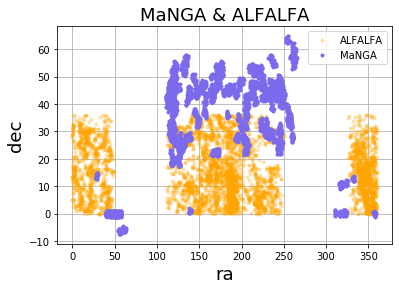

In [3]:
# 平面的 ra dec 星系分布图
plt.plot(alfa_ra,alfa_dec,'.',color = 'orange',label='ALFALFA',alpha=0.25)
plt.plot(manga_ra,manga_dec,'.',color = '#7c6aed',label='MaNGA',alpha=1)

plt.grid()

plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("MaNGA & ALFALFA",fontsize = 18)
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

In [ ]:
'''
1.进行 ra，dec的匹配
2.在上一步的基础上进行 ra,dec,z 的匹配
'''










In [55]:
# 去除重复匹配星系 
a,tmp_id = np.unique(idx_nsa2,return_index=True)
idx_manga = idx_manga[tmp_id]
idx_nsa2 = idx_nsa2[tmp_id]

array([0.09006098, 0.05019108, 0.00648212, 0.00499624, 0.07687799,
       0.00826791, 0.08844097, 0.06516471, 0.00605133, 0.09696732,
       0.08356621, 0.08753458, 0.04622475, 0.08795039, 0.06611847])

In [194]:
a100_data.head(5)

,AGCNr,Name,HIra,HIdec,OCra,OCdec,v21,w50,werr,flux,fluxerr,snratio,rms,dist,loghimass,detcode
0,311321,HIdetHVC,326.127930,34.989723,0.000000,0.000000,-336,24,0,6.62,0.16,20.7,13.57,0.0,0.00,9
1,311337,HIdetHVC,326.355011,20.348612,0.000000,0.000000,-327,22,0,0.89,0.03,14.5,2.75,0.0,0.00,9
2,311338,HIdetHVC,326.613312,20.491388,0.000000,0.000000,-292,27,1,1.23,0.03,17.0,2.80,0.0,0.00,9
3,311322,HIdetHVC,326.800415,35.691391,0.000000,0.000000,-331,23,0,9.99,0.13,38.6,11.32,0.0,0.00,9
4,11813,,326.879181,22.165277,326.879181,22.163889,1838,98,2,4.69,0.06,47.3,2.22,29.3,8.98,1


In [34]:
a2018_data.head(5)

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist,sigDist,logMH,siglogMH,HIcode
0,105367,........,0.00167,5.44333,0.00333,5.44250,11983,274,39,281,1.14,0.08,8.1,1.91,166.0,2.3,9.87,0.05,1
1,333313,........,0.00375,24.90889,359.99750,24.90750,11181,313,20,333,1.80,0.09,11.3,2.02,154.8,2.3,10.01,0.05,1
2,331060,478-009b,0.01042,23.08472,0.01417,23.08750,4463,160,4,184,1.96,0.07,14.7,2.35,50.6,10.4,9.07,0.18,1
3,331061,456-013.,0.01042,15.87222,0.00875,15.88167,6007,260,45,268,1.13,0.09,6.5,2.40,85.2,2.4,9.29,0.06,1
4,104570,........,0.00667,32.70834,0.00500,32.71028,10614,245,6,250,0.86,0.07,6.6,1.86,147.0,2.3,9.64,0.06,1


In [ ]:
# 读取 ra, dec, dist
a100 = pd.read_csv(a_100_path)
# dist --> z


# k3match 匹配
# 使用k3匹配：nsa&nair
idx_alfa, idx_manga, d = k3.cartesian
idx_nsa,idx_nair,d = k3.cartesian(nsa_data[:,0],nsa_data[:,1],nsa_data[:,2],
                                  nair_data[:,0],nair_data[:,1],nair_data[:,2],0.233)

In [ ]:
'''
MaNGA z 转为 哈勃距离 匹配
'''




In [ ]:
'''
使用 ALFALFA 中的 Velocity width of the HI line profile ——》z 和MaNGA匹配
这个数据真的就是退行速度？说明中指的是速度峰之间的宽度鸭？？？
'''

In [ ]:
'''
检查 Col 5 是否为退行速度
1.读取速度和距离
2.速度转换为距离
3.hist2D图检查是否在1：1线上
'''
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性
import numpy as np    # 数组
import matplotlib.pyplot as plt    # 画图[Matlab形式]
import warnings
import pandas as pd

# 导入 ALFALFA 数据
a_100_path = '/root/cosmos/data/alfalfa.100.csv'
a_2018_path = '/root/cosmos/data/alfalfa.2018.csv'
a100_data = pd.read_csv(a_100_path)
a2018_data = pd.read_csv(a_2018_path)
a100 = a100_data[['HIra','HIdec','dist']].values
a2018 = a2018_data[['RAdeg_HI','DECdeg_HI','Dist']].values
alfa_ra = a100[:,0]# a2018[:,0]
alfa_dec = a100[:,1]# a2018[:,1]



In [258]:
'''
使用SDSS提供的MaNGA和ALFALFA匹配结果
[https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=hi-manga-data-release-1]
'''
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性
import numpy as np    # 数组
import matplotlib.pyplot as plt    # 画图[Matlab形式]
import warnings
import pandas as pd
# warnings.filterwarnings('ignore')    # 不显示warning信息

# 读取 MaNGA-HI-ALFALFA 文件
ma_alfa = fits.open('/root/cosmos/data/manga_dr15_alfalfa.fits')
a_100_path = '/root/cosmos/data/alfalfa.100.csv'
a_2018_path = '/root/cosmos/data/alfalfa.2018.csv'

# 读取MaNGA数据
#ma_al_id = ma_alfa[1].data[['PLATEIFU','AGC']]
platifu = ma_alfa[1].data['PLATEIFU']
al_id = ma_alfa[1].data['AGC']
al_sn = ma_alfa[1].data['SNR']

# 读取 ALFALFA 数据
a100_data = pd.read_csv(a_100_path)
a2018_data = pd.read_csv(a_2018_path)
a100 = a100_data[['AGCNr','HIdec']].values
a2018 = a2018_data[['AGCNr','DECdeg_HI']].values
a100_id = a100[:,0]
a2018_id = a2018[:,0]

# 匹配ALFALFA的id，确认用的是哪个ALFALFA的数据
ax = al_id; ay=np.zeros(np.shape(al_id)[0]); az=np.zeros(np.shape(al_id)[0])
bx = a2018_id; by=np.zeros(np.shape(a2018_id)[0]); bz=np.zeros(np.shape(a2018_id)[0])
#bx = a100_id; by=np.zeros(np.shape(a100_id)[0]); bz=np.zeros(np.shape(a100_id)[0])
id_x, id_y, nst_d = k3.cartesian(ax,ay,az,bx,by,bz,1)

print("匹配到星系数量：",id_x.shape[0])
print("匹配到的星系的信噪比为：",al_sn[id_x])


# Test
print(np.shape(al_id))
print(np.shape(a2018_id))





# 关闭打开的fits文件
ma_alfa.close()

匹配到星系数量： 373
匹配到的星系的信噪比为： [ 19.8  77.2  14.1  41.5   9.8  24.2  24.6  23.5   7.5  14.5  13.5  23.2
   9.1   6.2  20.6  11.3   8.2   7.4  15.   11.5  20.4   5.6  13.8  17.1
   6.9  20.2   8.6  10.9  26.8   7.3  24.4   6.3   7.8  10.2   9.2  40.3
   5.2  23.9   9.5   6.5   6.6  10.    6.4  24.2  10.5  12.5  14.5   8.4
   6.6  24.9   6.4  12.2  11.6  14.3  13.6  11.1   6.2  51.6  13.   12.4
  14.5  13.2   9.4   5.8  24.8  19.5  11.1  10.1  17.5  31.4  21.    7.9
  26.3   7.9   8.8   9.3  11.8  17.4  11.4   9.1   8.7   7.4   8.6  11.2
  25.5   4.9   7.4  15.    7.7   7.5   4.6   7.7   9.3   9.1  19.2  24.6
  20.3  13.9  11.4  10.9   5.2  19.4   6.    8.7  39.4  17.3   4.9  35.1
   9.4  18.4   7.1   8.7  12.7  13.3  32.9  96.2   9.3  22.8   6.4  12.6
   6.5   9.1   8.2   9.3 116.4   5.9  12.3   6.5   6.6   6.5   8.5   7.7
   5.7  10.9   6.9  10.4  10.5  48.7  10.    6.4  11.4  17.7  10.   34.9
  12.9   6.5  27.9  15.   15.1  63.3   5.7  11.1   9.   23.    7.2   5.4
  13.2   8.   30.4   8.1 

In [305]:
a2018_data[a2018_data['SNR']>4.5].shape

(30718, 19)

(5067,)


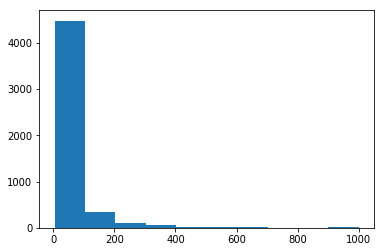

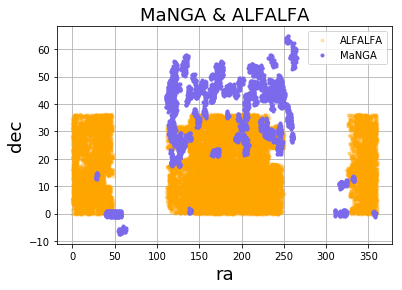

In [299]:
tmp = a100_data['snratio'].values
print(np.shape(tmp[tmp>4.5]))
plt.hist(tmp[tmp>4.5])
plt.show()

# 平面的 ra dec 星系分布图
plt.plot(alfa_ra,alfa_dec,'.',color = 'orange',label='ALFALFA',alpha=0.25)
plt.plot(manga_ra,manga_dec,'.',color = '#7c6aed',label='MaNGA',alpha=1)

###################################################################################
vac = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
manga_data = np.zeros([4675,2],dtype=float) # 初始化数组
basic = vac[1].data
# 获取ra和dec信息
manga_data[:,0] = copy(basic['OBJRA'])    # 去除只读属性
manga_data[:,1] = copy(basic['OBJDEC'])    # 去除只读属性

# 根据ra,dec画出星系分布图

# 获取ra,dec值
manga_ra = manga_data[:,0]
manga_dec = manga_data[:,1]
a100 = a100_data[['HIra','HIdec','dist']].values
a2018 = a2018_data[['RAdeg_HI','DECdeg_HI','Dist']].values
alfa_ra = a100[:,0]# a2018[:,0]
alfa_dec = a100[:,1]# a2018[:,1]
alfa_ra = alfa_ra[tmp>4.5]
alfa_dec = alfa_dec[tmp>4.5]

plt.grid()

plt.legend(loc = "best")# 设置图例
plt.xlabel("ra",fontsize = 18)
plt.ylabel("dec",fontsize = 18)
plt.title("MaNGA & ALFALFA",fontsize = 18)
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

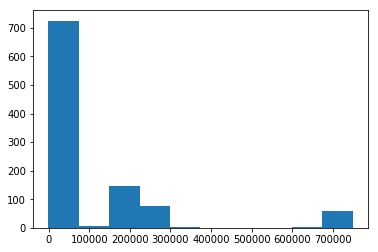

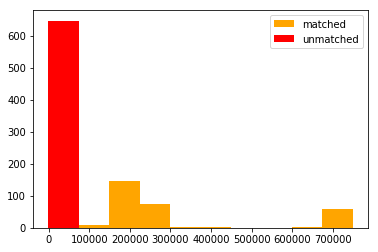

In [296]:
ma_alfa = fits.open('/root/cosmos/data/manga_dr15_alfalfa.fits')
test_value = ma_alfa[1].data['AGC']

al_sn = test_value

(n, bins, patches) = plt.hist(al_sn)
plt.show()

plt.hist(al_sn[id_x],bins=bins,color='orange',label="matched")

tmp = copy(al_sn)
tmp[id_x]=False
plt.hist(tmp[np.where(tmp!=False)],bins=bins,color='red',label="unmatched")
plt.legend(loc="best")
plt.show()

In [275]:
tmp = copy(al_sn)
tmp[id_x]=False
np.shape(tmp[np.where(tmp!=False)])

IndexError: index 6296 is out of bounds for axis 0 with size 1021

In [272]:
np.where(tmp!=False)

(array([   0,    1,    2,    3,    6,   11,   12,   19,   21,   22,   24,
          26,   29,   30,   31,   33,   36,   38,   39,   40,   43,   46,
          55,   56,   60,   61,   62,   64,   66,   67,   69,   75,   76,
          77,   81,   82,   85,   86,   87,   90,   91,   93,   95,   98,
          99,  101,  102,  103,  104,  106,  111,  117,  118,  120,  121,
         123,  126,  128,  130,  131,  133,  139,  141,  143,  144,  147,
         149,  157,  159,  160,  161,  164,  165,  168,  170,  172,  174,
         175,  176,  177,  179,  181,  183,  191,  193,  194,  196,  197,
         198,  200,  201,  203,  212,  213,  214,  215,  216,  218,  221,
         226,  232,  234,  235,  236,  238,  239,  244,  245,  246,  248,
         249,  252,  253,  254,  256,  257,  262,  265,  266,  267,  268,
         271,  273,  276,  277,  279,  283,  284,  286,  289,  291,  294,
         296,  297,  305,  306,  307,  308,  309,  310,  312,  313,  314,
         315,  316,  317,  320,  321, 

In [256]:
np.shape(ax[ax!=-999])

(373,)

In [274]:
648+373

1021

In [257]:
bx.min()

1.0

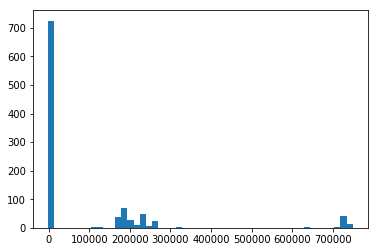

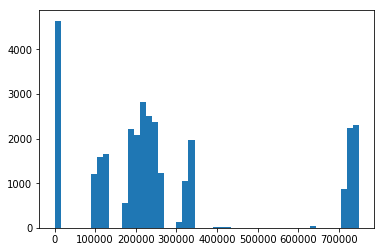

In [242]:
plt.hist(ax,bins=50);
plt.show()
plt.hist(bx,bins=50);
plt.show()

In [309]:
a = 10**6*3.26*365*24*3600
print( "%e"%a)

1.028074e+14


In [312]:
print( "%e"%100)

1.000000e+02


## 再次尝试MaNGA和ALFALFA星系匹配
1. 使用 ra dec 进行匹配
1. 统计 z 的差【是否为正态分布？】

# 使用MaNGA-HI & MaNGA-ALFALFA cross match

In [103]:
import pandas as pd
import numpy as np
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性&防止指针
from functools import partial

# 获取 MaNGA 数据
mg = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
mg_mgID = mg[1].data['MANGAID ']
mg_plifu = mg[1].data['PLATEIFU']

# 获取 MaNGA-HI 数据
mgHI = fits.open('/root/cosmos/data/mangaHIall.fits') 
HI_mgID = mgHI[1].data['mangaid']
HI_plifu = mgHI[1].data['plateifu']

# 获取 MaNGA-ALFALFA 匹配数据
mg_alfa = fits.open('/root/cosmos/data/manga_dr15_alfalfa.fits')
al_id = mg_alfa[1].data['AGC']
al_plifu = mg_alfa[1].data['PLATEIFU']

def match(x, MaNGA): 
    a = np.where(MaNGA==x)
    if np.size(a)==0:
        return False
    else:
        return a[0][0]
mtch = partial(match, MaNGA=mg_plifu)    # 转换为单参数函数

# 按照 plate-ifu 匹配
mtch_id1 = np.array(list(map(mtch, HI_plifu)),dtype=int)
# print("before = ",mtch_id)
mtch_id2 = np.array(list(map(mtch, al_plifu[np.where(al_id!=-999)])),dtype=int)

matched_mg = np.zeros(4675)
# tmpid = (mg_plifu == HI_plifu)
matched_mg[mtch_id1] += 1
matched_mg[mtch_id2] += 1
print("匹配总星系数量为： ", matched_mg.sum())
print("匹配到一次的星系总数量为： ",matched_mg[np.where(matched_mg==1)].sum())

matched_plifu = mg_plifu[np.where(matched_mg==1)]
print("最终MaNGA中，拥有HI数据的星系有 %d 个"%np.shape(matched_plifu)[0])

匹配总星系数量为：  704.0
匹配到一次的星系总数量为：  704.0
最终MaNGA中，拥有HI数据的星系有 704 个


# 金属丰度反常星系
+ 拼接字符串方法：
> `filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))`  
> `filename = path_marvin_maps+'/manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(str(plate)+'-'+str(ifu))`

+ 拼接函数方法
> func = getattr（函数，方法） = 函数.方法   
> `elt = getattr(maps,'emline_gflux_'+element)    # 拼接变量名称`

## MaNGA星系图片&emsp;|&emsp;照片

In [99]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from os.path import join
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息

# MaNGA光学图片
def MaNGA_image(plateifu):
    '''
    plateifu : 字符串格式，例如 '8551-3701'
    '''
    path_image_data = '/root/cosmos/data/images'
    # show the image
    image_path = join(path_image_data, '{}.png'.format(''.join(plateifu)))
    temp_image = mpimg.imread(image_path)
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.title(plateifu,fontsize=18)
    plt.imshow(temp_image) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    return

from marvin.tools import Maps
from os.path import join
# MaNGA各元素图片【Flux】
def MaNGA_element_image(plateifu, element):
    '''
    plateifu : 字符串格式，例如 '8551-3701'
    element : 字符串格式，例如 'nii_6585' 'ha_6564'
    '''
    path_marvin_maps = '/root/bash_file/manga_maps_data'
    filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join(plateifu)))
    maps = Maps(filename=filename)
    elt = getattr(maps,'emline_gflux_'+element)    # 拼接变量名称
    fig,ax,__= elt.plot(cmap='jet', log_cb=True, return_cb=True)
    fig.set_size_inches(5, 3)    # 调整大小
    ax.set_title(plateifu+' '+"flux: "+element)
    return

# 测试
# MaNGA_image('8551-3701')
# MaNGA_element_image('8551-3701','nii_6585')

## pyqz插值求得金属丰度

## ALM区域条件

In [ ]:
# 只对 偏差>0 的部分进行拟合！！！
# 求 ALM 条件！！！

# 计算每个spaxel的预期金属丰度
# 得到 number of spaxels - metallicity deviation图
# 再加上高斯分布的拟合，对比二者得到ALM区域的标准

'''
1. 求出 expected metallicity
2. obs - exp 求出偏差
3. 得到 金属丰度偏差 的分布直方图
'''
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

# 读取数据
cc = np.where(mass_spaxel>=math.pow(10,8.5))# 挑选出星系质量>10^8.5Msun 的spaxels
mass_sel = cc[0]
sel_spaxel_data = spaxel_data[mass_sel].copy()
sel_mass_spaxel = mass_spaxel[mass_sel].copy()
sel_Znew = Znew[mass_sel].copy()
sel_density = firefly_spaxel_density[mass_sel].copy() #firefly_spaxel_density[mass_sel]
den_Z = expeted_data[::-1].copy()# 待插值的 密度，金属丰度 数据点

# 插值方法
kind = 'linear'#'linear'# 'cubic'# interpolation method 

range_mass = np.array([[8.5,9],[9,9.5],[9.5,10],[10,12]])
for_mass = range_mass[::-1]

# 初始化 预期金属丰度 数组
Z_exp = np.ones([sel_Znew.size,1])*np.nan
Z_dev = np.ones([sel_Znew.size,1])*np.nan
i = 0# 循环计数变量
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = den_Z[20*i:20*i+20,0]
    y = den_Z[20*i:20*i+20,1]
    # 去除不想要的黄色点
    if c=='yellow0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    # 去除不想要的绿色点
    if c=='green':
        x[np.where(x>8.5)[0]]=np.nan
        y[np.where(x>8.5)[0]]=np.nan
    # 去除不想要的红色点
    if c=='red0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    # 去除不想要的褐色点
    if c=='brown0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    lala = (~np.isnan(x))&(~np.isnan(y))
    f=interpolate.interp1d(x[lala],y[lala],fill_value="extrapolate",kind=kind)# 使用插值函数
    #xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
    xnew = np.linspace(7,9.4,100)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    
    # 获取每个spaxel的预期金属丰度
    ii = for_mass[i]
    idspaxel = (sel_mass_spaxel>=math.pow(10,ii[0]))&(sel_mass_spaxel<math.pow(10,ii[1]))
    Z_exp[idspaxel] = f(sel_density[idspaxel[:,0]])
    Z_dev[idspaxel] = sel_Znew[idspaxel[:,0]] - Z_exp[idspaxel]
    i+=1

plt.title("Expected matallicity",fontsize=16)
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
plt.legend(loc='best',title='$log(M_*/M_\odot)$')#loc='lower right'
plt.xlim([6,10.5])
plt.ylim([7.8,9])
plt.show()

# 金属丰度偏差
# Z_dev = sel_Znew - Z_exp

# 筛选出 星系质量>10^9Msun 的spaxels
cc = np.where(sel_mass_spaxel>=math.pow(10,9))[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
Z_dev = Z_dev[cc]
Z_exp = Z_exp[cc]
sel_spaxel_data = sel_spaxel_data[cc]
sel_mass_spaxel = sel_mass_spaxel[cc]
dd = np.where(sel_density>7)[0]# 挑选出surface mass density>10^7的spaxels
Z_dev = Z_dev[dd]
Z_exp = Z_exp[dd]
sel_spaxel_data = sel_spaxel_data[dd]
sel_mass_spaxel = sel_mass_spaxel[dd]
sel_density = sel_density[dd]

# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# hist,bins = np.histogram(Z_dev,bins=150);
# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
yy = yy[np.where(xx>0.02)]
xx = xx[np.where(xx>0.02)]
print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################

# # ALM 标准
# y_exp = gaus(x,*popt)
# delta_y = y - y_exp
# delta_y = delta_y[np.where(x<-0.1)]
# x = x[np.where(x<-0.1)]
# ALM = x[np.where(delta_y==delta_y.max())]
# plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

# 高斯分布和实际分布的差
oldx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
oldy = hist.copy()# 数量
delta_y = oldy - gaus(oldx,*popt)
delta_y = delta_y[np.where(oldx<0)]
oldx = oldx[np.where(oldx<0)]
ALM = oldx[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
# plt.plot(oldx,delta_y,'k--')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.show()

## ALM星系 | 图片

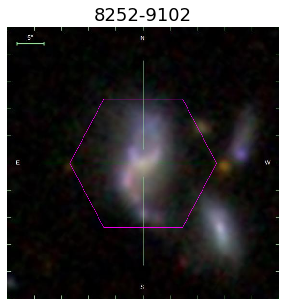

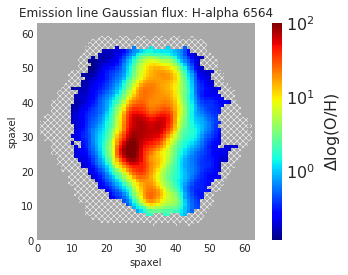

In [53]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
from os.path import join

# Marvin's fits.gz file Path and images path
path_marvin_maps = '/root/bash_file/manga_maps_data'
path_image_data = '/root/cosmos/data/images'

# Galaxy ID plate-ifu
plate = 8252
ifu = 9102

#maps = Maps('8252-9102')
#filename = '/root/cosmos/galaxies-mzr/data/manga-8077-6104-MAPS-HYB10-GAU-MILESHC.fits.gz'
#maps = Maps(filename=filename)
filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
maps = Maps(filename=filename)

nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564
# a = getattr(self,'emline_gflux_'+str('ha_6564')).text()
# a = locals()['emline_gflux_'+str('ha_6564')].text()
i = 'ha_6564'
ha = getattr(maps,'emline_gflux_'+str(i))
# ha = maps.a
# show the image
image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])
temp_image = mpimg.imread(image_path)
fig, ax = plt.subplots(figsize=(5, 5))
plt.title(name_pla_ifu,fontsize=18)
plt.imshow(temp_image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


fig, ax, cb=ha.plot(cmap='jet',cblabel='Flux( $10^{-17}$ erg s$^{-1}$) spaxel$^{-1}$ cm$^{-2}$',log_cb=True,cbrange=(0.0001,100),return_cb=True)
cb.set_ticks([0.1, 1, 10, 100])
cb.set_ticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'])
cb.set_label('$\Delta$log(O/H)',fontsize=16,labelpad=8)
#cb.cb_kws={'axloc': [0.8, 0.1, 0.03, 5 / 6.]}

